In [109]:
#from ABDB import database as db
import matplotlib.pyplot as plt
import numpy as np
from retrain_ablooper import *
import torch
import pandas as pd
from rich import print as pprint
from ABlooper import CDR_Predictor
import os

Cannot do refinement


Own code for relaxing sturcutres

In [2]:
# torch settings
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_dtype(torch.float)

model = MaskDecoyGen(decoys=5).to(device = device).float()
model.load_state_dict(torch.load('best_models/best_model-2804-Radam-5-2optim', map_location=torch.device(device)))

batch_size = 1

train = torch.load('train_data/train.pt')
validation = torch.load('train_data/val.pt')
test = torch.load('train_data/test.pt')

val_dataloader = torch.utils.data.DataLoader(validation, 
                                             batch_size=batch_size,
                                             num_workers=1,
                                             shuffle=False,
                                             pin_memory=True,
                                             )

test_dataloader = torch.utils.data.DataLoader(test[:1], 
                                              batch_size=batch_size,
                                              num_workers=1,
                                              shuffle=False,
                                              pin_memory=True,
                                              )

In [3]:
for i in range(5):
    tmp = MaskDecoyGen(decoys=1).to(device = device).float()
    dict=torch.load("best_models/best_model-0305-Radam-1-2optim-"+str(i+1), map_location=torch.device(device))
    tmp.load_state_dict(dict)
    weights = tmp.blocks[0].state_dict()

    model.blocks[i].load_state_dict(weights)

In [4]:
def produce_full_structures_of_val_set(val_dataloader, model, outdir='', relax=True, to_be_rewritten=["H1", "H2", "H3", "L1", "L2", "L3"]):
    '''
    Produces full FAB structure for a dataset
    '''
    CDR_rmsds_not_relaxed = list()
    CDR_rmsds_relaxed = list()
    decoy_diversities = list()
    order_of_pdbs = list()

    with torch.no_grad():
        model.eval()

        for data in track(val_dataloader, description='predict val set'):

            # predict sturcture using the model
            coordinates, geomout, node_feature, mask, id = data['geomins'].float().to(device), data['geomouts'].float().to(device), data['encodings'].float().to(device), data['mask'].float().to(device), data['ids']
            pred = model(node_feature, coordinates, mask)
            CDR_rmsds_not_relaxed.append(rmsd_per_cdr(pred, node_feature, geomout).tolist())
            pred = pred.squeeze() # remove batch dimension
            
            # get framework info from pdb file
            pdb_id, heavy_c, light_c, pdb_file = get_info_from_id(id)
            chains = [heavy_c, light_c]
            order_of_pdbs.append(pdb_id)

            with open(pdb_file) as file:
                pdb_text = [line for line in file.readlines()]
                
            pdb_text = pdb_select_hc_lc(pdb_text, chains)

            CDR_with_anchor_slices, atoms, CDR_text, CDR_sequences, CDR_numberings, CDR_start_atom_id = get_framework_info(pdb_text, chains)

            predicted_CDRs = {}
            all_decoys = {}
            decoy_diversity = {}

            for i, CDR in enumerate(CDR_with_anchor_slices):
                output_CDR = pred[:, node_feature[0, :, 30 + i] == 1.0]
                all_decoys[CDR] = rearrange(output_CDR, "b (i a) d -> b i a d", a=4).cpu().numpy()
                predicted_CDRs[CDR] = rearrange(output_CDR.mean(0), "(i a) d -> i a d", a=4).cpu().numpy()
                decoy_diversity[CDR] = (output_CDR[None] - output_CDR[:, None]).pow(2).sum(-1).mean(-1).pow(
                    1 / 2).sum().item() / 20
            
            decoy_diversities.append(list(decoy_diversity.values()))
            
            text_prediction_per_CDR = convert_predictions_into_text_for_each_CDR(CDR_start_atom_id, predicted_CDRs, CDR_sequences, CDR_numberings, CDR_with_anchor_slices)
            old_text = pdb_text

            for CDR in to_be_rewritten:
                new = True
                new_text = []
                chain, CDR_slice = CDR_with_anchor_slices[CDR]
                CDR_slice = (CDR_slice[0] + 2, CDR_slice[1] - 2)

                for line in old_text:
                    if not filt(line, chain, CDR_slice):
                        new_text.append(line)
                    elif new:
                        new_text += text_prediction_per_CDR[CDR]
                        new = False
                    else:
                        continue
                old_text = new_text

            header = [
                "REMARK    CDR LOOPS REMODELLED USING ABLOOPER                                   \n"]
            new_text = header + old_text

            with open('pdbs/'+outdir+'/'+pdb_id+'-'+heavy_c+light_c+'.pdb', "w+") as file:
                file.write("".join(new_text))

            with open('pdbs/'+outdir+'/'+pdb_id+'-'+heavy_c+light_c+'-true.pdb', "w+") as file:
                file.write("".join(pdb_text))

            if relax:
                relaxed_text = openmm_refine(old_text, CDR_with_anchor_slices)
                header.append("REMARK    REFINEMENT DONE USING OPENMM" + 42 * " " + "\n")
                relaxed_text = header + relaxed_text

                with open('pdbs/'+outdir+'/'+pdb_id+'-'+heavy_c+light_c+'-relaxed.pdb', "w+") as file:
                    file.write(''.join(relaxed_text))


                # calculate rmsds of relaxed structures
                CDR_with_anchor_slices, atoms, CDR_text, CDR_sequences, CDR_numberings, CDR_start_atom_id = get_framework_info(relaxed_text, chains)
                
                CDR_BB_coords = extract_BB_coords(CDR_text, CDR_with_anchor_slices, CDR_sequences, atoms)

                relaxed_coords = prepare_model_output([CDR_BB_coords])[0]
            
                relaxed_coords = pad_tensor(relaxed_coords)
                relaxed_coords = rearrange(relaxed_coords, 'i x -> () () i x')
                CDR_rmsds_relaxed.append(rmsd_per_cdr(relaxed_coords, node_feature, geomout).tolist())


    return CDR_rmsds_not_relaxed, CDR_rmsds_relaxed, decoy_diversities, order_of_pdbs

In [14]:
def cdr_rmsd_of_2_pdb_files(prediction_path, true_path, chains):
    
    with open(prediction_path, 'r') as file:
        pdb_text_pred = [line for line in file.readlines()]

    with open(true_path, 'r') as file:
        pdb_text_true = [line for line in file.readlines()]

    pdb_text_true = pdb_select_hc_lc(pdb_text_true, chains)
    pdb_text_pred = pdb_select_hc_lc(pdb_text_pred, chains)
    
    CDR_with_anchor_slices, atoms, CDR_text_true, _, _, _ = get_framework_info(pdb_text_true, chains)
    _, _, CDR_text_pred, _, _, _ = get_framework_info(pdb_text_pred, chains)
    
    CDR_texts = [CDR_text_true, CDR_text_pred]
    for CDR_text in CDR_texts:
        for CDR in CDR_with_anchor_slices:
            new = [line for line in CDR_text[CDR] if line.split()[2] in atoms]
            new = [line for line in new if (line.split()[5][-1].isalpha() or int(line.split()[5]) >= CDR_with_anchor_slices[CDR][1][0] + 2)]
            new = [line for line in new if (line.split()[5][-1].isalpha() or int(line.split()[5]) <= CDR_with_anchor_slices[CDR][1][1] - 2)]
        
            CDR_text[CDR] = new
    
    CDR_BB_coors_true = {}
    CDR_BB_coors_pred = {}
    CDR_BB_coors = [CDR_BB_coors_true, CDR_BB_coors_pred]
    for i in range(len(CDR_texts)):
        for CDR in CDR_with_anchor_slices:
            coords = [[float(line.split()[6]), float(line.split()[7]), float(line.split()[8])] for line in CDR_texts[i][CDR]]
            coords = np.array(coords)
            
            CDR_BB_coors[i][CDR] = coords
            
    rmsds = []
    for CDR in CDR_with_anchor_slices:
        true = CDR_BB_coors[0][CDR]
        pred = CDR_BB_coors[1][CDR]
        
        rmsd = np.sqrt(((pred - true) ** 2).sum(-1).mean())
        rmsds.append(rmsd)
        
        
    return np.array(rmsds)

In [37]:
dir = '/data/localhost/not-backed-up/spoendli/pdbs/0305-Radam-1-2optim-test/'

files = os.listdir(dir)
files = [file for file in files if file != 'metrics.json']

files = [file[:7] for file in files if file[0] != '.']
files = list(set(files))

ids = []
rmsds = []

for i in range(len(files)):
    chains = (files[i][-2], files[i][-1])
        
    true_path = dir+files[i]+'-true.pdb'
    relaxed_path = dir+files[i]+'-relaxed.pdb'
    
    ids.append(files[i])
    rmsds.append(cdr_rmsd_of_2_pdb_files(relaxed_path, true_path, chains))

rmsds = np.array(rmsds)

In [38]:
rmsds.mean(0)

array([1.17081381, 1.09165272, 2.46593909, 0.90204051, 0.92089803,
       1.13564884])

In [ ]:
def rmsd(prediction, truth):
    dists = (prediction - truth).pow(2).sum(-1)
    return torch.sqrt(dists.nanmean(-1)).mean()

In [126]:
dir = '0305-Radam-1-2optim-test'

In [127]:
cdr_rmsds, CDR_rmsds_relaxed, decoy_diversities, pdb_ids = produce_full_structures_of_val_set(test_dataloader, 
                                                                                              model, 
                                                                                              outdir=dir, 
                                                                                              relax=True)

/data/localhost/not-backed-up/spoendli/miniconda3/envs/ab/lib/python3.8/site-packages/rich/li
ve.py:221: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

In [135]:
pdb_ids, cdr_rmsds, CDR_rmsds_relaxed

(['3oz9'],
 [[0.39621397852897644,
   0.5520344972610474,
   2.0543265342712402,
   0.5045629143714905,
   0.1996065378189087,
   1.3235737085342407]],
 [[1.6838728189468384,
   1.7694529294967651,
   2.6591641902923584,
   1.8018285036087036,
   1.6651703119277954,
   2.0778539180755615]])

Calculate rmsds of relaxed structures

In [66]:
import os
from ABDB import database as db
import matplotlib.pyplot as plt
import numpy as np
from retrain_ablooper import *
import torch
import pandas as pd
from rich import print as pprint
from ABlooper import CDR_Predictor
from einops import rearrange

In [86]:
dir = '/data/localhost/not-backed-up/spoendli/pdbs/0305-Radam-1-2optim-test/'

In [104]:
files = os.listdir(dir)
[file for file in files if file != 'metrics.json']

['3i9g-HL.pdb',
 '4nzu-HL.pdb',
 '4nzu-HL-true.pdb',
 '3go1-HL.pdb',
 '4hpy-HL-true.pdb',
 '1gig-HL-relaxed.pdb',
 '3g5y-BA-true.pdb',
 '3giz-HL-relaxed.pdb',
 '2fb4-HL.pdb',
 '1mlb-BA.pdb',
 '3gnm-HL-relaxed.pdb',
 '1dlf-HL-true.pdb',
 '2fb4-HL-relaxed.pdb',
 '3m8o-HL-true.pdb',
 '2e27-HL-true.pdb',
 '1gig-HL.pdb',
 '3t65-BA-true.pdb',
 '2ypv-HL-true.pdb',
 '1mfa-HL-true.pdb',
 '3go1-HL-relaxed.pdb',
 '1mfa-HL.pdb',
 '2xwt-AB-true.pdb',
 '2fbj-HL-relaxed.pdb',
 '4f57-HL-true.pdb',
 '3g5y-BA-relaxed.pdb',
 '3v0w-HL-relaxed.pdb',
 '2vxv-HL-relaxed.pdb',
 '3liz-HL.pdb',
 '3i9g-HL-relaxed.pdb',
 '1mfa-HL-relaxed.pdb',
 '3ifl-HL-relaxed.pdb',
 '3p0y-HL.pdb',
 '3eo9-HL-true.pdb',
 '2d7t-HL.pdb',
 '2e27-HL-relaxed.pdb',
 '3t65-BA-relaxed.pdb',
 '3ifl-HL-true.pdb',
 '2d7t-HL-true.pdb',
 '3m8o-HL.pdb',
 '3mlr-HL-true.pdb',
 '4h20-HL-true.pdb',
 '2r8s-HL.pdb',
 '3mxw-HL.pdb',
 '3oz9-HL-true.pdb',
 '3go1-HL-true.pdb',
 '3t65-BA.pdb',
 '2vxv-HL-true.pdb',
 '2r8s-HL-true.pdb',
 '2w60-AB-true.pdb',

In [109]:
def cdr_rmsds_on_pdb_file(prediction_path, truth_path, chains):

    pred = CDR_Predictor(prediction_path, chains = chains)
    pred_coords = prepare_model_output([pred.CDR_BB_coords])[0]
    pred_coords = rearrange(pred_coords, 'i x -> () () i x')
    pred_nodefeatures = pred.prepare_model_input()[0]
    
    truth = CDR_Predictor(truth_path, chains)
    truth_coords = prepare_model_output([truth.CDR_BB_coords])[0]
    truth_coords = rearrange(truth_coords, 'i x -> () i x')

    cdr_rmsds = rmsd_per_cdr(pred_coords, pred_nodefeatures, truth_coords)

    return cdr_rmsds

def rmsds_pred_and_relaxed(dir):

    files = os.listdir(dir)
    files.remove('metrics.json')
    files = [file[:7] for file in files if file[0] != '.']
    files = list(set(files))
    
    ids = list()
    rmsds_pred = np.zeros((len(files), 6))
    rmsds_relaxed = np.zeros((len(files), 6))

    for i in range(len(files)):
        chains = (files[i][-2], files[i][-1])
        
        truth_path = dir+files[i]+'-true.pdb'
        pred_path = dir+files[i]+'.pdb'
        relaxed_path = dir+files[i]+'-relaxed.pdb'

        ids.append(files[i])
        rmsds_pred[i,:] = np.array(cdr_rmsds_on_pdb_file(pred_path, truth_path, chains).tolist())
        rmsds_relaxed[i,:] = np.array(cdr_rmsds_on_pdb_file(relaxed_path, truth_path, chains).tolist())

    return ids, rmsds_pred, rmsds_relaxed

In [110]:
ids, rmsd_pred, rmsd_relaxed = rmsds_pred_and_relaxed(dir)


In [114]:
rmsd_relaxed.mean(0)

array([1.16327669, 1.09427714, 2.47645663, 0.90324465, 0.92075492,
       1.13739726])

In [117]:
from ABDB import database as db
from ABDB.AbPDB import AntibodyParser
import numpy as np
import Bio.PDB
parser = AntibodyParser(PERMISSIVE=True, QUIET=True)
parser.set_numbering_scheme("imgt")
db.set_numbering_scheme("imgt")
backbone = ["CA","C","N", "CB"]

def CDR_rmsds(pdb, file, fab_n = 0, chains = ["H", "L"], decoy_chains = ["H", "L"]):
    fab = db.fetch(pdb).fabs[fab_n]
    rmsds = {}
    for h_or_l in chains:
        #Truth load
        chain = db.db_summary[pdb]["fabs"][fab_n][h_or_l+"chain"]
        truth = fab.get_structure()[chain]
        #Decoy load
        decoy = parser.get_antibody_structure(pdb+"_model", file)[0][{"H":decoy_chains[0], "L":decoy_chains[1]}[h_or_l]]
        #Numbering
        numb = [(" ", *x) for x in fab.get_numbering()[h_or_l]][2:-2]
        #Get residues to align
        truth_res = [truth[x] for x in numb if (x in decoy) and (x in truth)]
        decoy_res = [decoy[x] for x in numb if (x in decoy) and (x in truth)]
        #Get atoms to align
        fixed = []
        moved = []
        for i in range(len(decoy_res)):
            fixed += [truth_res[i][atom] for atom in backbone if (atom in decoy_res[i]) and (atom in truth_res[i])]
            moved += [decoy_res[i][atom] for atom in backbone if (atom in decoy_res[i]) and (atom in truth_res[i])]
        #Calculate superimposer and move decoy
        imposer = Bio.PDB.Superimposer()
        imposer.set_atoms(fixed, moved)
        imposer.apply(decoy.get_atoms())
        rmsds[h_or_l] = imposer.rms
        # Find CDR definitions
        loop_definitions = {x[3:]:[(" ", *y[0]) for y in fab.get_CDR_sequences(definition="imgt")[x]]  for x in fab.get_CDR_sequences(definition="imgt")}
        # Calculate RMSD for each CDR
        for CDR in loop_definitions:
            if CDR[0] == h_or_l:
                true_loop = []
                decoy_loop = []
                for res in loop_definitions[CDR]:
                    if (res in truth) and (res in decoy):
                        true_loop += [truth[res][x].get_coord() for x in backbone if (x in decoy[res]) and (x in truth[res])]
                        decoy_loop+= [decoy[res][x].get_coord() for x in backbone if (x in decoy[res]) and (x in truth[res])]
                #Calculate RMSD
                rmsds[CDR] = np.sqrt(np.mean(3*(np.array(true_loop) - np.array(decoy_loop))**2))
                
    # Calculate RMSD for framework
    ignore = sum([loop_definitions[x] for x in loop_definitions if x[0] == h_or_l], [])
    frame_def = [x for x in numb if x not in ignore]
    
    true_frame, decoy_frame = [], []
    for res in frame_def:
        if (res in truth) and (res in decoy):
            true_frame += [truth[res][x].get_coord() for x in backbone if (x in decoy[res]) and (x in truth[res])]
            decoy_frame+= [decoy[res][x].get_coord() for x in backbone if (x in decoy[res]) and (x in truth[res])]
    rmsds[h_or_l] = np.sqrt(np.mean(3*(np.array(true_frame) - np.array(decoy_frame))**2))
                
    return rmsds

In [137]:
pdb = db.fetch('5hdq')
for fab in pdb.fabs:
    print(fab)

fab HL
	VH = chain H
	VL = chain L


In [139]:
CDR_rmsds('3oz9', '/data/localhost/not-backed-up/spoendli/pdbs/0305-Radam-1-2optim-test/3oz9-HL.pdb', fab_n = 0, chains = ["H", "L"], decoy_chains = ["H", "L"])

{'H': 1.0492338462729975,
 'H1': 1.7875236,
 'H2': 1.8640847,
 'H3': 2.464813,
 'L': 0.072361894,
 'L1': 1.7554567,
 'L2': 1.762282,
 'L3': 2.0607486}

In [89]:
node_feature_seqs = []
for node_feat in node_feats:
    cdr_seq = {'H1': '', 'H2': '', 'H3': '', 'L1': '', 'L2': '', 'L3': '', 'Anchor': ''}
    for i in range(0, node_feat.shape[1]):
        if get_atom_type(node_feat[0, i]) == 'C':
            resn = long2short[get_amino_type(node_feat[0, i])]
            loop = get_loop(node_feat[0, i])

            cdr_seq[loop]+=resn


    #cdr_seq['H1'] = cdr_seq['Anchor'][:2]+cdr_seq['H1']+cdr_seq['Anchor'][2:4]
    #cdr_seq['H2'] = cdr_seq['Anchor'][4:6]+cdr_seq['H2']+cdr_seq['Anchor'][6:8]
    #cdr_seq['H3'] = cdr_seq['Anchor'][8:10]+cdr_seq['H3']+cdr_seq['Anchor'][10:12]
    #cdr_seq['L1'] = cdr_seq['Anchor'][12:14]+cdr_seq['L1']+cdr_seq['Anchor'][14:16]
    #cdr_seq['L2'] = cdr_seq['Anchor'][16:20]+cdr_seq['L2']+cdr_seq['Anchor'][20:22]
    #cdr_seq['L3'] = cdr_seq['Anchor'][22:24]+cdr_seq['L3']+cdr_seq['Anchor'][24:26]
    del cdr_seq['Anchor']
    node_feature_seqs.append(cdr_seq)


In [120]:
differences = []
for i in range(46):
    difference = False
    for CDR in seq_rel[i]:
        if node_feature_seqs[i][CDR] != seq_rel[i][CDR][2:-2]:
            difference = True
        
    if difference:
        differences.append(i)

In [109]:
len(differences)

0

In [94]:
def compare(a, b):
    print(a['H1'])
    print(b['H1'][2:-2])
    print('--')
    print(a['H2'])
    print(b['H2'][2:-2])
    print('--')
    print(a['H3'])
    print(b['H3'][2:-2])
    print('--')
    print(a['L1'])
    print(b['L1'][2:-2])
    print('--')
    print(a['L2'])
    print(b['L2'][2:-2])
    print('--')
    print(a['L3'])
    print(b['L3'][2:-2])

In [119]:
n = 44

compare(node_feature_seqs[n], seq_rel[n])

GFNLYSSS
GFNLYSSS
--
ISSSYGYT
ISSSYGYT
--
ARRAAGMSTYGFDY
ARRAAGMSTYGFDY
--
QSVSSA
QSVSSA
--
SAS
SAS
--
QQSYSSPIT
QQSYSSPIT


pymol to calculate rmsds

In [21]:
from pymol import cmd

['105', '117']

In [126]:
dir = 'pdbs/0305-Radam-1-2optim-test/'

files = os.listdir(dir)
files = [file[:7] for file in files if file != 'metrics.json']
files = list(set(files))

cdr_slices = [['27', '38'], ['56', '65'], ['105', '117'], ['27', '38'], ['56', '65'], ['105', '117']]
cdr_rmsds_pred = np.zeros((46, 6))
cdr_rmsds_relaxed = np.zeros((46, 6))
pdb_ids = []

for i in range(len(files)):

    file = files[i]

    pdb_ids.append(file)

    chains = (file[-2], file[-1])

    xray = file + '-true'
    pred = file
    relaxed = file + '-relaxed'

    cmd.load(dir + xray +'.pdb')
    cmd.load(dir + pred +'.pdb')
    cmd.load(dir + relaxed +'.pdb')

    for j in range(6):
        slice = cdr_slices[j]
        chain = 0 if j < 3 else 1
        
        pred_rmsd = cmd.align(pred + ' and chain ' + chains[chain] + ' and resi ' + slice[0] + '-' + slice[1] + ' and (name CA or name CB or name C or name N)', 
                              xray + ' and chain ' + chains[chain] + ' and resi ' + slice[0] + '-' + slice[1] + ' and (name CA or name CB or name C or name N)', cycles=0, transform=0)[0]
        cdr_rmsds_pred[i, j] = pred_rmsd
        
        relax_rmsd = cmd.align(relaxed + ' and chain ' + chains[chain] + ' and resi ' + slice[0] + '-' + slice[1] + ' and (name CA or name CB or name C or name N)', 
                               xray + ' and chain ' + chains[chain] + ' and resi ' + slice[0] + '-' + slice[1] + ' and (name CA or name CB or name C or name N)', cycles=0, transform=0)[0]
        cdr_rmsds_relaxed[i, j] = relax_rmsd



pprint(cdr_rmsds_relaxed[0])
pprint(cdr_rmsds_pred[0])

[1.00706768 0.87227124 2.61044312 0.87674153 0.86157286 1.18686891]

[1.90060496 1.78474176 2.85382438 1.82311523 1.7777319  1.98858249]

In [135]:
i = 20
print(pdb_ids[i])
pprint(cdr_rmsds_relaxed[i])
pprint(cdr_rmsds_pred[i])

3nps-BC


[1.61433649 1.03000677 2.70819068 0.84815079 0.87682092 1.10235012]

[2.06302047 1.89087248 2.98012161 1.80779552 1.73424077 1.83068395]

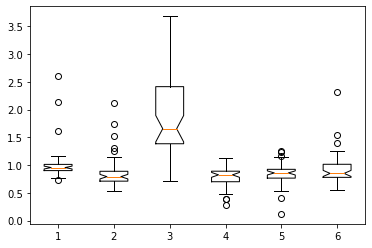

In [132]:
plt.boxplot([x for x in cdr_rmsds_relaxed.T], [x for x in str(range(6))]);

In [139]:
cmd.align('3nps-BC-relaxed and chain B and resi 62 and name CB', 
          '3nps-BC-true and chain B and resi 62 and name CB',
          cycles=0, transform=0)

(0.0, 1, 0, 0.0, 1, 6.0, 1)

In [140]:
cmd.align('3nps-BC and chain B and resi 62 and name CB', 
          '3nps-BC-true and chain B and resi 62 and name CB',
          cycles=0, transform=0)

(0.0, 1, 0, 0.0, 1, 6.0, 1)